In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, date

In [2]:
df = pd.read_csv("us-counties.csv", header = 0)
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [29]:
ala_df = df[(df.county == 'Alachua')]
ala_df.county.unique()

array(['Alachua'], dtype=object)

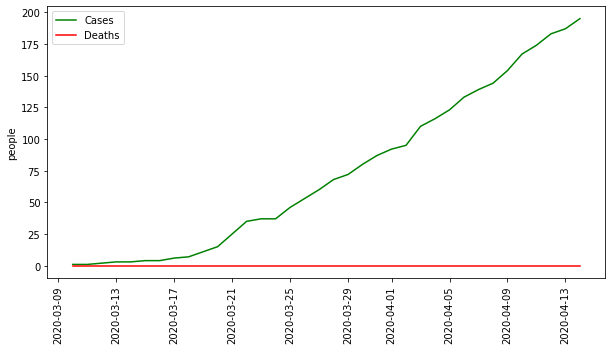

In [30]:
# Visualize the Alachua data
dates = pd.to_datetime(ala_df.date)
cases = ala_df.cases.values
deaths = ala_df.deaths.values
day = datetime(2020, 3, 15)
day_0 = datetime(2020, 3, 11)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(dates, cases, c = "green")
ax.plot(dates, deaths, c = "red")
#ax.plot([day_0,day],[0, 30])
plt.ylabel("people")
plt.xticks(rotation=90)
plt.legend(["Cases", "Deaths"])

In [5]:
day_count = np.arange(len(cases))
day_count

array([   0,    1,    2, ..., 1758, 1759, 1760])

# Basic SIR Model

ValueError: x and y must have same first dimension, but have shapes (1761,) and (36,)

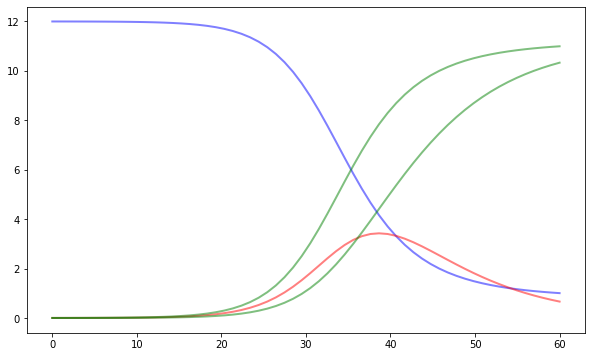

In [31]:
from scipy.integrate import odeint
# Total population, N.
N = 12001
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.4, 1./7.2 
# A grid of time points (in days)
t = np.linspace(0, 60, 60)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(figsize=(10,6),facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, (I+R)/1000, 'g', alpha=0.5, lw=2, label='Cases')
ax.plot(day_count, cases/1000, 'o', alpha=0.5, lw=2, label='Alachua')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,13)
ax.set_xlim(0,60)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

In [32]:
#Set Plot SIR function
def plot_SIR(N, b, g, day_count, cases, days, I0, constant):
    N = N
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = I0, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma = b, g
    # A grid of time points (in days)
    t = np.linspace(0, days, days)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    fig = plt.figure(figsize=(10,6),facecolor='w')
    ax = fig.add_subplot(111,axisbelow=True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.plot(t, (I+R)/1000, 'orange', alpha=0.5, lw=2, label='Cases')
    ax.plot(day_count, cases*constant/1000, 'o', alpha=0.5, lw=2, label='Real Data')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

# SEIR Model

In [33]:
from scipy.integrate import solve_ivp
# Total population, N.
N = 12001
# Initial number of infected and recovered individuals, I0 and R0.
E0, I0, R0 = 15, 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - E0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, sigma, gamma = 2.2, 1./5.2, 1./7.5
# A grid of time points (in days)

# The SIR model differential equations.
def deriv(t, y, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = (beta * S * I / N) - (sigma * E)
    dIdt = sigma * E - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, E0, I0, R0
t = [0,150]
# Integrate the SIR equations over the time grid, t.
ret = solve_ivp(deriv, t, y0, args = (N, beta, sigma, gamma))
#S, E, I, R = ret.T

fits = ret.y
S, E, I, R = fits
t = ret.t

ValueError: x and y must have same first dimension, but have shapes (1761,) and (36,)

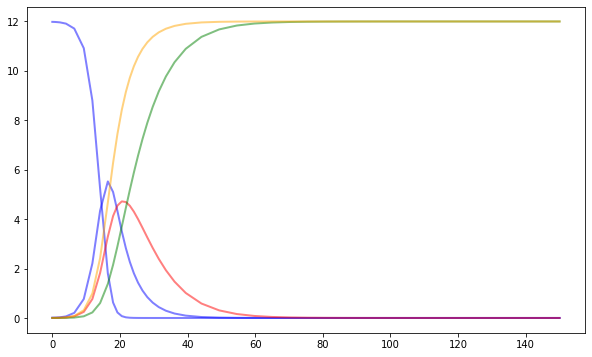

In [34]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
constant = 45
fig = plt.figure(figsize=(10,6),facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'b', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, (I+R)/1000, 'orange', alpha=0.5, lw=2, label='Cases')
ax.plot(day_count, cases/1000*constant, 'o', alpha=0.5, lw=2, label='Alachua')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,12)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

# Fit SIR model

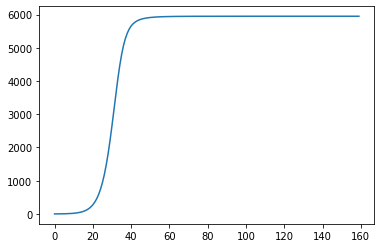

In [35]:
#Define the equation
def SIR(t,y):
    beta = 0.4
    gamma = 1/7.2
    N = y[0]
    I = y[1]
    R = y[2]
    S = N - I - R
    return([-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I])

sol = solve_ivp(SIR,[0,160],[12001, 1, 0],t_eval=np.arange(0,160,1))
plt.plot(sol.t, sol.y[1]+sol.y[2])

In [11]:
def sumsq(p):
    beta, gamma, c= p
    def SIR(t,y):
        N = y[0]
        I = y[1]
        R = y[2]
        S = N - I - R
        return([-beta*S*I, beta*S*I - gamma*I, gamma*I])
    sol = solve_ivp(SIR,[0,len(cases)],[12001,1,0],t_eval=np.arange(0,len(cases),1))
    print(p)
    return(sum((sol.y[1]+sol.y[2]-cases*c)**2))

In [12]:
def mod_sumsq(p):
    d, c= p
    def SIR(t,y):
        beta, gamma = 0.4, 1/7.2
        N = y[0]
        I = y[1]
        R = y[2]
        S = N - I - R
        return([-beta*S*I, beta*S*I - gamma*I, gamma*I])
    sol = solve_ivp(SIR,[d, d+len(cases)],[12001,1,0],t_eval=np.arange(d, d+len(cases),1))
    print(p)
    return(sum((sol.y[1]+sol.y[2]-cases*c)**2))

In [13]:
#### from scipy.optimize import minimize
from scipy.optimize import minimize
bnds = ((0, 15), (1, 200))
msol = minimize(mod_sumsq,[15,20], bounds = bnds, method='L-BFGS-B',
               options={'disp': True})
print(msol)
#msol.x

[15. 20.]
[15.00000001 20.        ]
[15.         20.00000001]
[0. 1.]
[1.e-08 1.e+00]
[0.         1.00000001]
[0.         2.14207425]
[1.00000000e-08 2.14207425e+00]
[0.         2.14207426]
[0.         2.58057769]
[1.00000000e-08 2.58057769e+00]
[0.        2.5805777]
[0.         2.58057237]
[1.00000000e-08 2.58057237e+00]
[0.         2.58057238]
[0.         2.58057532]
[1.00000000e-08 2.58057532e+00]
[0.         2.58057533]
[0.         2.58057369]
[1.00000000e-08 2.58057369e+00]
[0.        2.5805737]
[0.         2.58057295]
[1.00000000e-08 2.58057295e+00]
[0.         2.58057296]
[0.         2.58057335]
[1.00000000e-08 2.58057335e+00]
[0.         2.58057336]
[0.         2.58057295]
[1.00000000e-08 2.58057295e+00]
[0.         2.58057296]
      fun: 59559034321.87189
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1525.87890625, -11444.09179688])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 30
      nit: 4
   status: 0
  success: Tru

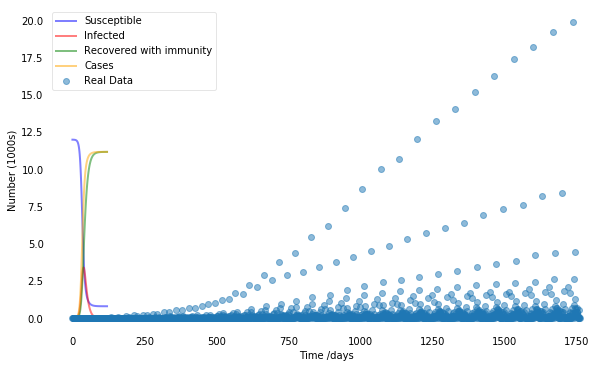

In [14]:
plot_SIR(12001,0.4, 1/7.2, day_count+msol.x[0], cases, 120, 1 ,msol.x[1])

# Data from Globe 

In [15]:
GB_df = pd.read_csv("time_series_covid19_confirmed_global.csv")
GB_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,367,423,444,484,521,555,607,665,714,784
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,377,383,400,409,416,433,446,467,475,494
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,525,545,564,583,601,601,638,646,659,673
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,16,17,19,19,19,19,19,19,19,19


In [16]:
China_df = GB_df[(GB_df["Province/State"] == "Hubei")].T
Italy_df = GB_df[(GB_df["Country/Region"] == "Italy")].T

In [17]:
Italy_df.head()

,137
Province/State,NaN
Country/Region,Italy
Lat,43
Long,12
1/22/20,0


Text(0, 0.5, 'Cases')

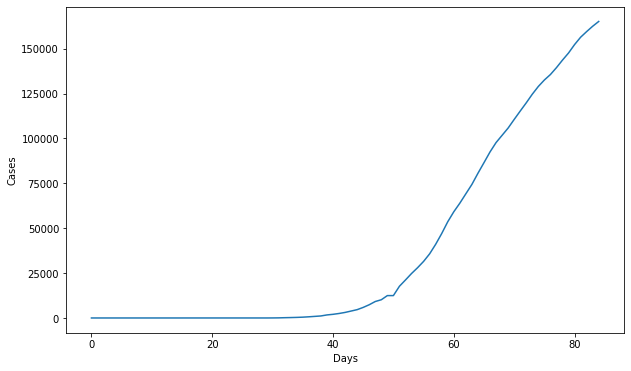

In [18]:
cases_it = Italy_df[137].values[4:]
day_it = np.arange(len(cases_it))
fig = plt.figure(figsize=(10,6),facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(day_it, cases_it)
ax.set_xlabel("Days")
ax.set_ylabel("Cases")

# Plot SEIR Model for Italy

In [19]:
from scipy.integrate import solve_ivp
# Total population, N.
N = 60484278
# Initial number of infected and recovered individuals, I0 and R0.
E0, I0, R0 = 2, 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - E0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, sigma, gamma = 0.9, 1./5.2, 1./7.5
# A grid of time points (in days)

# The SIR model differential equations.
def deriv(t, y, N, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = (beta * S * I / N) - (sigma * E)
    dIdt = sigma * E - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, E0, I0, R0
t = [0,150]
# Integrate the SIR equations over the time grid, t.
ret = solve_ivp(deriv, t, y0, args=(N, beta, sigma, gamma))
#S, E, I, R = ret.T

fits = ret.y
S, E, I, R = fits
t = ret.t

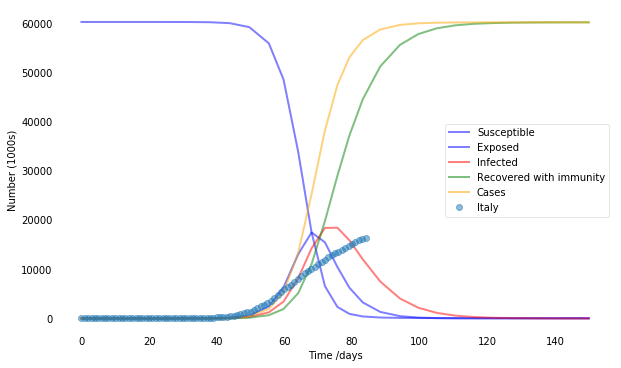

In [20]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
constant = 100
fig = plt.figure(figsize=(10,6),facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'b', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, (I+R)/1000, 'orange', alpha=0.5, lw=2, label='Cases')
ax.plot(day_it, cases_it/1000*constant, 'o', alpha=0.5, lw=2, label='Italy')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

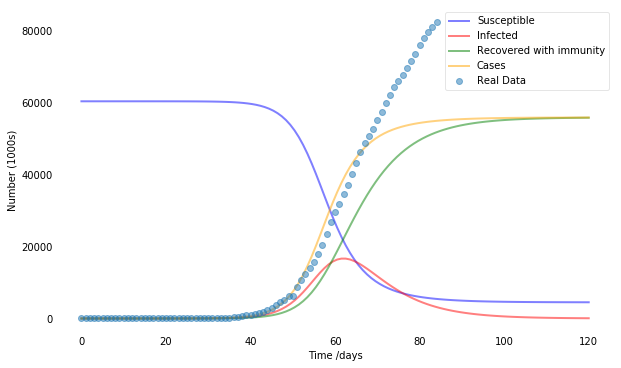

In [21]:
plot_SIR(60484278, 0.39, 1/7.2, day_it, cases_it, 120, 20, constant =500)

In [22]:
#Fit Italy
def sumsq(p):
    beta, gamma, c, d= p
    def SIR(t,y):
        N = y[0]
        I = y[1]
        R = y[2]
        S = N - I - R
        return([-beta*S*I/N, beta*S*I/N - gamma*I, gamma*I])
    sol = solve_ivp(SIR,[d,d+len(cases_it)],[60484278,10,0],t_eval=np.arange(d,d+len(cases_it),1))
    return(sum((sol.y[1]+sol.y[2]-cases_it*c)**2))
    print(c)
    return(sum(((sol.y[1]+sol.y[2]-cases_it*constant))**2))

from scipy.optimize import minimize
bnds = ((0, 1), (0, 1),(0, 60), (0, 100))
msol_it = minimize(sumsq,[0.4,1/7.2,10,20], bounds = bnds, method='SLSQP',
               options={'disp': True})
msol_it.x

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2.2281197647202212e+16
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1


array([ 0.4       ,  0.13888889, 10.        , 20.        ])

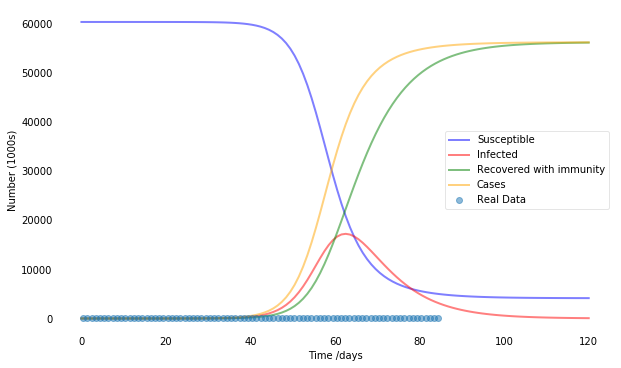

In [23]:
#def plot_SIR(N, b, g, day_count, cases, days, I0, constant):
plot_SIR(60484278,0.4,1/7.2, day_it+msol_it.x[0], cases_it, 120, 10 ,msol_it.x[1])

Text(0, 0.5, 'Cases')

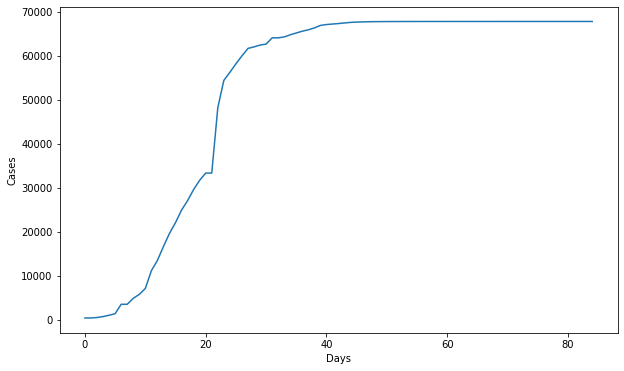

In [24]:
cases_ch = China_df[62].values[4:]
day_ch = np.arange(len(cases_ch))
fig = plt.figure(figsize=(10,6),facecolor='w')
ax = fig.add_subplot(111,axisbelow=True)
ax.plot(day_ch, cases_ch)
ax.set_xlabel("Days")
ax.set_ylabel("Cases")

In [25]:
len(np.arange(40, 40 + len(cases_it),1))

85

# Fitting SIR

In [26]:
def sumsq(c):
    delay, constant= c
    divs = 1000
    def SIR(t,y):
        beta, gamma = 0.4,1/7.2
        N = y[0]/divs
        I = y[1]/divs
        R = y[2]/divs
        S = N - I - R
        return([-beta*S*I/N, beta*S*I-gamma*I/N, gamma*I])
    sol = solve_ivp(SIR,[delay,delay + len(cases_ch)],[58510000,10,0],t_eval=np.arange(delay, 
                                                                                        delay + len(cases_it),1))
    print(c)
    return(sum(((sol.y[1]+sol.y[2]-cases_ch*constant))**2))

In [27]:
from scipy.optimize import minimize
bnds = ((5., 100.), (0., None))
msol = minimize(sumsq,[20.,900.], bounds = bnds, method='SLSQP',
               options={'disp': True})
msol.x

[ 20. 900.]
[ 20. 900.]
[ 20.00000001 900.        ]
[ 20.         900.00000001]
[2.00000000e+01 1.20994597e+13]
[2.00000000e+01 1.20994598e+12]
[2.00000000e+01 1.20994598e+11]
[2.00000000e+01 1.20994606e+10]
[2.00000000e+01 1.20994687e+09]
[2.00000000e+01 1.20995497e+08]
[2.00000000e+01 1.21003597e+07]
[2.00000000e+01 1.21084597e+06]
[2.00000000e+01 1.21894597e+05]
[   20.         12999.45974374]
[  20.         2109.94597437]
[  20.         2109.94597437]
[  20.00000001 2109.94597437]
[  20.         2109.94597439]
[ 20.         921.39231799]
[ 20.         921.39231799]
[ 20.00000001 921.39231799]
[ 20.       921.392318]
[ 20.         921.39136878]
[ 20.         921.39136878]
[ 20.00000001 921.39136878]
[ 20.         921.39136879]
[ 20.         921.37713064]
[ 20.         921.38841864]
[ 20.         921.38841864]
[ 20.00000001 921.38841864]
[ 20.         921.38841866]
[ 20.        921.3895987]
[ 20.         921.38884402]
[ 20.         921.38859763]
[ 20.        921.3884983]
[ 20.       

array([ 20.      , 921.388419])

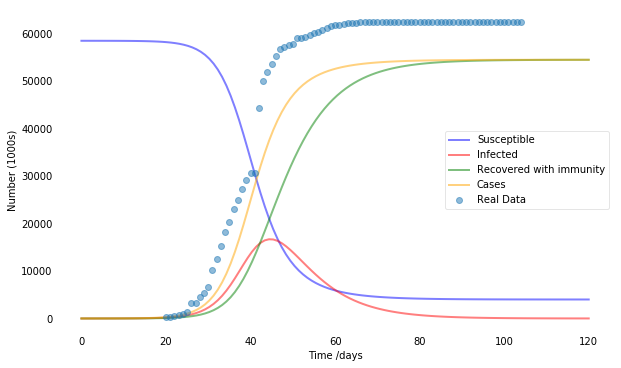

In [28]:
#def plot_SIR(N, b, g, day_count, cases, days, I0, constant):
plot_SIR(58510000,0.4,1/7.2, day_ch+msol.x[0], cases_ch, 120, 1000 ,msol.x[1])